In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Rescaling all the images**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

train_normalize = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,         # Apply random shearing transformations
    zoom_range=0.2,          # Randomly zoom in or out by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest',      # Fill in new pixels with the nearest pixel value
)

test_normalize = ImageDataGenerator(rescale=1./255)
val_normalize = ImageDataGenerator(rescale=1./255)

# **Load the images from their own directory**

In [5]:
train_set = train_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Train/Train",target_size=(256,256),class_mode='categorical', shuffle=True)
val_set   = val_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Validation/Validation", target_size=(256, 256), class_mode="categorical", shuffle=True)
test_set  = test_normalize.flow_from_directory(directory="/kaggle/input/plant-disease-recognition-dataset/Test/Test",target_size=(256,256),class_mode="categorical", shuffle=True)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [6]:
unique, counts = np.unique(train_set.labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 458, 1: 430, 2: 434}


In [7]:
train_set.image_shape

(256, 256, 3)

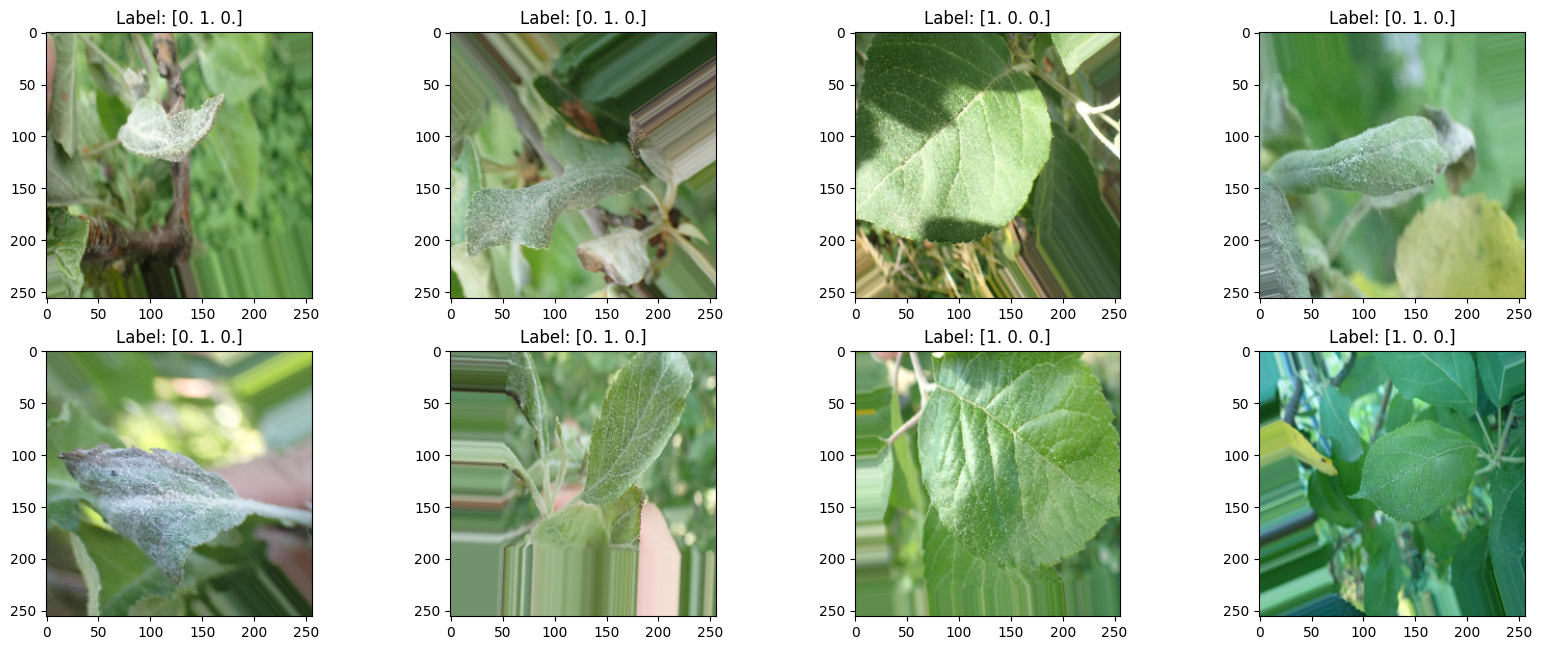

In [8]:
import matplotlib.pyplot as plt

image_batch, image_label = next(train_set)

plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image_batch[i])
    plt.title(f"Label: {image_label[i]}")

plt.show()

In [9]:
train_set.labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

# **apply MobileNet as feature extraction**

In [10]:
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.models import Model
# import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256 ,3), classes = 3)

x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)
# base_model.summary()

/tmp/ipykernel_1595/3434090922.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256 ,3), classes = 3)


In [11]:
# from tensorflow.keras.utils import plot_model

# plot_model(base_model,show_layer_names=True,show_shapes=True)

In [12]:
train_features = model.predict(train_set)
val_features   = model.predict(val_set)
test_features  = model.predict(test_set)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/42 ━━━━━━━━━━━━━━━━━━━━ 7:49 11s/step

I0000 00:00:1722779280.876448    1670 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 8s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


In [13]:
train_features.shape

(1322, 1280)

flatten features

In [14]:
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [15]:
train_features.shape

(1322, 1280)

# **apply SelectPercentile for feature selection**

In [16]:
labels = train_set.classes
labels.shape

(1322,)

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k_best = 520  # Adjust as needed
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)

train_selected = selector.fit_transform(train_features, labels)

selected_features = selector.get_support()

In [18]:
np.sum(train_selected==True)

test_selected = selector.transform(test_features)

val_selected = selector.transform(val_features)

In [19]:
# from sklearn.feature_selection import SelectPercentile , GenericUnivariateSelect
# from sklearn.feature_selection import chi2 , f_classif
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# #k_best = 400  # Adjust as needed

# feature_selection = SelectPercentile(score_func = chi2 , percentile = 20)

# train_selected = feature_selection.fit_transform(train_features, train_set.classes)
# test_selected = feature_selection.transform(test_features)
# val_selected = feature_selection.transform(val_features)

# **apply Support Vector Machine (SVM) for calssification**

In [20]:
# train_selected = train_selected.reshape(-1, 1)

In [21]:
train_set.labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


svm_classifier = SVC(kernel='sigmoid')

svm_classifier.fit(train_selected, train_set.classes)

# Step 3: Evaluate on the validation set
validation_predictions = svm_classifier.predict(val_selected)
validation_accuracy = accuracy_score(val_set.classes, validation_predictions)
print(f'Validation Accuracy: {validation_accuracy}')

Validation Accuracy: 0.35


In [24]:
# Step 4: Evaluate on the test set
test_predictions = svm_classifier.predict(test_selected)
print(np.mean(test_predictions == test_set.classes))
test_accuracy = accuracy_score(test_set.classes, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

0.32
Test Accuracy: 0.32


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

**precision:**True Positive / (True Positive + False Positive)

In [26]:
Precision = precision_score(test_set.labels, test_predictions, average='weighted', zero_division=0)
print(Precision,"of data that is predicted as true was exactly true")

0.32475332475332475 of data that is predicted as true was exactly true


**Recall:** True Positive / (True Positive + False Negative)

In [27]:
recall = recall_score(test_set.labels, test_predictions, average='weighted')
print(recall, "of the actual true data was predicted as true")

0.32 of the actual true data was predicted as true


**F1 score:** 2 * ((Precision * recall) / (Precision + recall))

In [28]:
F1_score = f1_score(test_set.labels, test_predictions, average="weighted")
F1_score

0.2756016385048643

**confusion matrix:**

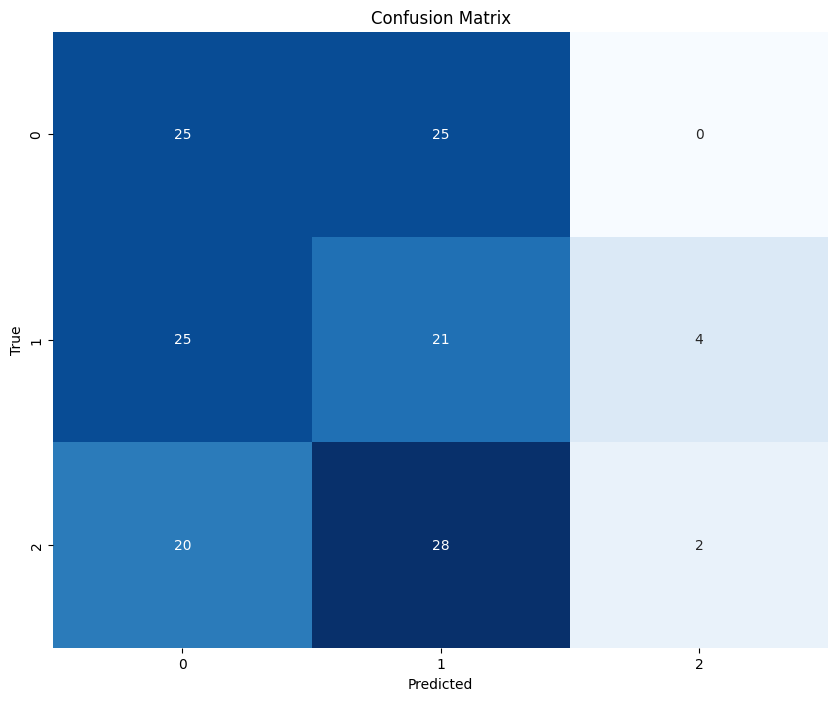

In [29]:
import seaborn as sns

conf_matrix = confusion_matrix(test_set.classes, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=sorted(np.unique(test_set.labels)),
            yticklabels=sorted(np.unique(test_set.labels)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
print(classification_report(test_set.labels  , test_predictions))

              precision    recall  f1-score   support

           0       0.36      0.50      0.42        50
           1       0.28      0.42      0.34        50
           2       0.33      0.04      0.07        50

    accuracy                           0.32       150
   macro avg       0.32      0.32      0.28       150
weighted avg       0.32      0.32      0.28       150

